In [9]:
# Importar librerias 

import pandas as pd
import itertools
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve
from sklearn.metrics import auc as sklearn_auc
import torch.optim as optim
from sklearn.metrics import f1_score, precision_score, recall_score, matthews_corrcoef, roc_auc_score
import copy

# Manejo de datos

## 1. De CSV a DataFrame

In [ ]:
# 1. Cargar y evaluar la dimensionalidad de los datos

df_data = pd.read_csv('data.csv').drop(columns=["Unnamed: 0"])
df_labels = pd.read_csv('labels.csv')
print("Dimensionalidad de datos:", df_data.shape)
print("Dimensionalidad de datos:", df_labels.shape)
print("Categorías verdaderas únicas:", df_labels.Class.unique())

df_data.head()

X = df_data.values
y = df_labels["Class"].values

## 2. Separación de datos en entrenamiento y prueba

In [ ]:
# Primero train/test
X_train_full, X_test, y_train_full, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Partimos train en train/validation
X_train, X_val, y_train, y_val = train_test_split(
    X_train_full, y_train_full,
    test_size=0.2,
    random_state=42,
    stratify=y_train_full
)

print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

## Escalamiento y reducción de dimensionalidad 

In [ ]:
# 3. Escalando solo con TRAIN

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled   = scaler.transform(X_val)
X_test_scaled  = scaler.transform(X_test)

In [ ]:
# 4. PCA solo con TRAIN

pca = PCA(n_components=200, random_state=42)
X_train_pca = pca.fit_transform(X_train_scaled)
X_val_pca   = pca.transform(X_val_scaled)
X_test_pca  = pca.transform(X_test_scaled)

## Codificar los Labels 

In [ ]:
# 5. Labels codificados

le = LabelEncoder()
y_train_enc = le.fit_transform(y_train)
y_val_enc   = le.transform(y_val)
y_test_enc  = le.transform(y_test)


## 3. De Pandas DataFrame a PyTorch DataSet

In [ ]:
# 6. Dataset

class PerfilesDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.long)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

train_dataset = PerfilesDataset(X_train_pca, y_train_enc)
val_dataset   = PerfilesDataset(X_val_pca, y_val_enc)
test_dataset  = PerfilesDataset(X_test_pca, y_test_enc)


# Definición de `device` para entrenamiento

In [ ]:
# 7. Device

device = "cuda" if torch.cuda.is_available() else "cpu"
print("Device disponible para entrenamiento:", device)

# Diseño de la arquitectura de la red neuronal

In [ ]:
# En mi caso serían 200 neuronas de entrada porque es la cantidad de genes que tiene mi dataLoader 
# y 5 neuronas de salida porque ese es el npumero de categorías que tengo 
# 128 nodos 
# según la literatura se recomienda la siguente estructura: 

class MLP(nn.Module):
    def __init__(self):
        super().__init__()
        self.capas = nn.Sequential(
            nn.Linear(200, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 5)
        )
    def forward(self, x):
        return self.capas(x)

# Entrenamiento y validación con Grid 

## Hiper parámetros 

In [ ]:
batch_sizes = [8, 16, 32, 64]
learning_rates = [1e-3, 1e-5, 3e-5]
epochs_list = [6, 10, 20, 40, 100]

## Busqueda con el grid 

In [ ]:
param_grid = list(itertools.product(batch_sizes, learning_rates, epochs_list))

results = []

best_model_state = None
best_params = None
best_val_f1 = -1

criterion = nn.CrossEntropyLoss()

for batch_size, lr, num_epochs in param_grid:

    print(f"\nProbando BS={batch_size}, LR={lr}, EP={num_epochs}")

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader   = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

    model = MLP().to(device)
    optimizer = optim.Adam(model.parameters(), lr=lr)


    # ENTRENAMIENTO
    for epoch in range(num_epochs):
        model.train()
        for xb, yb in train_loader:
            xb, yb = xb.to(device), yb.to(device)

            optimizer.zero_grad()
            logits = model(xb)
            loss = criterion(logits, yb)
            loss.backward()
            optimizer.step()

   
    # MÉTRICAS TRAIN
    model.eval()
    train_losses, train_preds, train_labels = [], [], []

    with torch.no_grad():
        for xb, yb in train_loader:
            xb, yb = xb.to(device), yb.to(device)
            logits = model(xb)
            loss = criterion(logits, yb)
            train_losses.append(loss.item())

            pred = torch.argmax(logits, 1).cpu().numpy()
            train_preds.extend(pred)
            train_labels.extend(yb.cpu().numpy())

    train_f1 = f1_score(train_labels, train_preds, average="weighted")
    train_loss = np.mean(train_losses)

    
    # MÉTRICAS VALIDACIÓN
    val_losses, val_preds, val_labels = [], [], []

    with torch.no_grad():
        for xb, yb in val_loader:
            xb, yb = xb.to(device), yb.to(device)
            logits = model(xb)
            loss = criterion(logits, yb)
            val_losses.append(loss.item())

            pred = torch.argmax(logits, 1).cpu().numpy()
            val_preds.extend(pred)
            val_labels.extend(yb.cpu().numpy())

    val_f1 = f1_score(val_labels, val_preds, average="weighted")
    val_loss = np.mean(val_losses)

    
    # DETECTOR DE SOBREAJUSTE

    gap_f1 = train_f1 - val_f1
    gap_loss = val_loss - train_loss

    overfit = (gap_f1 > 0.10) and (gap_loss > 0.10)

    
    # GUARDAR RESULTADOS DEL GRID
    results.append({
        "batch_size": batch_size,
        "learning_rate": lr,
        "epochs": num_epochs,
        "Train_F1": train_f1,
        "Val_F1": val_f1,
        "Train_Loss": train_loss,
        "Val_Loss": val_loss,
        "Overfitting": overfit
    })

    
    # ELEGIR EL MEJOR MODELO
    if (not overfit) and (val_f1 > best_val_f1):
        best_val_f1 = val_f1
        best_model_state = copy.deepcopy(model.state_dict())
        best_params = (batch_size, lr, num_epochs)

torch.save(best_model_state, "mejor_modelo_mlp_3.mod")


# 10. GUARDAR TABLA DE RESULTADOS DEL GRID

df_results = pd.DataFrame(results)
df_results.to_csv("metricas_grid_mlp.csv", index=False)
print(df_results)


Device: cpu

Probando BS=8, LR=0.001, EP=6

Probando BS=8, LR=0.001, EP=10

Probando BS=8, LR=0.001, EP=20

Probando BS=8, LR=0.001, EP=40

Probando BS=8, LR=0.001, EP=100

Probando BS=8, LR=1e-05, EP=6

Probando BS=8, LR=1e-05, EP=10

Probando BS=8, LR=1e-05, EP=20

Probando BS=8, LR=1e-05, EP=40

Probando BS=8, LR=1e-05, EP=100

Probando BS=8, LR=3e-05, EP=6

Probando BS=8, LR=3e-05, EP=10

Probando BS=8, LR=3e-05, EP=20

Probando BS=8, LR=3e-05, EP=40

Probando BS=8, LR=3e-05, EP=100

Probando BS=16, LR=0.001, EP=6

Probando BS=16, LR=0.001, EP=10

Probando BS=16, LR=0.001, EP=20

Probando BS=16, LR=0.001, EP=40

Probando BS=16, LR=0.001, EP=100

Probando BS=16, LR=1e-05, EP=6

Probando BS=16, LR=1e-05, EP=10

Probando BS=16, LR=1e-05, EP=20

Probando BS=16, LR=1e-05, EP=40

Probando BS=16, LR=1e-05, EP=100

Probando BS=16, LR=3e-05, EP=6

Probando BS=16, LR=3e-05, EP=10

Probando BS=16, LR=3e-05, EP=20

Probando BS=16, LR=3e-05, EP=40

Probando BS=16, LR=3e-05, EP=100

Probando BS=

,Best_batch_size,Best_lr,Best_epochs,Test_F1,Test_Precision,Test_Recall,Test_MCC
0,8,0.001,6,0.987503,0.987679,0.987578,0.983631


## Evaluación con TEST 

In [ ]:
best_model = MLP().to(device)
best_model.load_state_dict(best_model_state)
best_model.eval()

test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

test_preds, test_labels, test_losses = [], [], []

with torch.no_grad():
    for xb, yb in test_loader:
        xb, yb = xb.to(device), yb.to(device)
        logits = best_model(xb)
        loss = criterion(logits, yb)

        test_losses.append(loss.item())
        pred = torch.argmax(logits, 1).cpu().numpy()
        test_preds.extend(pred)
        test_labels.extend(yb.cpu().numpy())

test_f1 = f1_score(test_labels, test_preds, average="weighted")
test_precision = precision_score(test_labels, test_preds, average="weighted")
test_recall = recall_score(test_labels, test_preds, average="weighted")
test_mcc = matthews_corrcoef(test_labels, test_preds)

df_test = pd.DataFrame([{
    "Best_batch_size": best_params[0],
    "Best_lr": best_params[1],
    "Best_epochs": best_params[2],
    "Test_F1": test_f1,
    "Test_Precision": test_precision,
    "Test_Recall": test_recall,
    "Test_MCC": test_mcc
}])

df_test.to_csv("metricas_finales_test_mlp.csv", index=False)
df_test


# Gráficas del mejor modelo 

In [11]:
# Cargar el mejor modelo 

best_model = MLP().to(device)
best_model.load_state_dict(torch.load("mejor_modelo_mlp_3.mod"))
best_model.eval()

/tmp/ipykernel_1844007/2089080793.py:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  best_model.load_state_dict(torch.load("mejor_modelo_mlp_3.mod"))


MLP(
  (capas): Sequential(
    (0): Linear(in_features=200, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=64, bias=True)
    (3): ReLU()
    (4): Linear(in_features=64, out_features=5, bias=True)
  )
)

## Matriz de confusión 

In [12]:
# Predicciónes del set de prueba

all_logits = []
all_labels = []

with torch.no_grad():
    for batch_x, batch_y in DataLoader(test_dataset, batch_size=32, shuffle=False):
        batch_x = batch_x.to(device)

        logits = best_model(batch_x)           # (batch, num_classes)
        all_logits.append(logits.cpu().numpy())
        all_labels.extend(batch_y.numpy())

all_logits = np.vstack(all_logits)            # todas las predicciones
all_labels = np.array(all_labels)

preds = np.argmax(all_logits, axis=1)         # clases predichas
probs = torch.softmax(torch.tensor(all_logits), dim=1).numpy()  # probabilidades

num_classes = probs.shape[1]

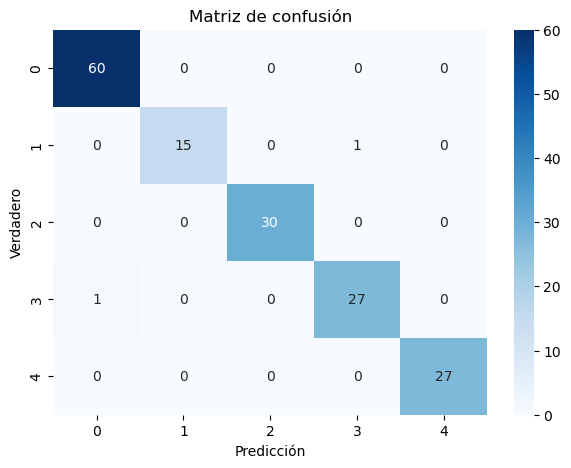

<Figure size 640x480 with 0 Axes>

In [13]:
# Graficar mi matriz 

cm = confusion_matrix(all_labels, preds)

plt.figure(figsize=(7,5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicción")
plt.ylabel("Verdadero")
plt.title("Matriz de confusión")
plt.show()
plt.savefig('MatrizConfusion_mejor_modelo_mlp.png') 

## Gráfica de la curva ROC

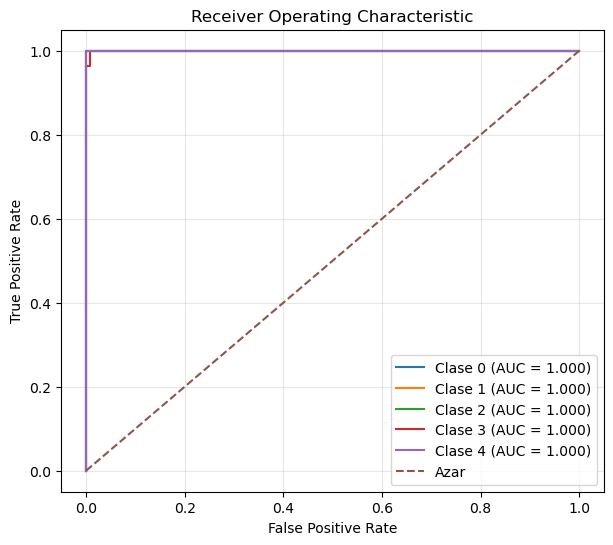

<Figure size 640x480 with 0 Axes>

In [14]:
y_bin = label_binarize(all_labels, classes=list(range(num_classes)))

plt.figure(figsize=(7, 6))

for i in range(num_classes):
    fpr, tpr, _ = roc_curve(y_bin[:, i], probs[:, i])
    roc_auc = sklearn_auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f"Clase {i} (AUC = {roc_auc:.3f})")

plt.plot([0, 1], [0, 1], linestyle="--", label="Azar")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver Operating Characteristic")
plt.legend()
plt.grid(alpha=0.3)
plt.show()
plt.savefig('AUCROC_mejor_modelo_mlp.png') 


# Usar mejor modelo entrenado


In [5]:
def predict(dataloader, modelo):
    modelo.eval()
    with torch.no_grad():
        for X, y in dataloader:
            X = X.to(device)
            y = y.to(device)

            logits = modelo(X)

            # predicción (entero)
            pred = logits.argmax(1).item()

            # verdadero (entero)
            true = y.item()

            print(f"Logits: {logits}")
            print(f"Predicción (entero): {pred}")
            print(f"Verdadero (entero): {true}")
            print("------------------------------")


In [6]:
mejor_modelo = MLP().to(device)
mejor_modelo.load_state_dict(torch.load("mejor_modelo_mlp_3.mod"))
mejor_modelo.eval()

/tmp/ipykernel_1844007/1227759051.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  mejor_modelo.load_state_dict(torch.load("mejor_modelo_mlp_3.mod"))


MLP(
  (capas): Sequential(
    (0): Linear(in_features=200, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=64, bias=True)
    (3): ReLU()
    (4): Linear(in_features=64, out_features=5, bias=True)
  )
)

In [7]:
dataset_test = PerfilesDataset(X_test_pca, y_test_enc)
dataloader_predict = DataLoader(dataset_test, batch_size=1, shuffle=False)

In [8]:
predict(dataloader_predict, mejor_modelo)

Logits: tensor([[-4.0708, -3.2025,  2.6909, -1.4863,  0.1199]])
Predicción (entero): 2
Verdadero (entero): 2
------------------------------
Logits: tensor([[ 6.9426, -3.6986, -2.6021, -3.7802, -2.7209]])
Predicción (entero): 0
Verdadero (entero): 0
------------------------------
Logits: tensor([[ 6.2455, -2.5907, -2.6347, -2.8028, -2.1564]])
Predicción (entero): 0
Verdadero (entero): 0
------------------------------
Logits: tensor([[-3.1839, -3.6026, -4.1452, -3.3122,  8.4868]])
Predicción (entero): 4
Verdadero (entero): 4
------------------------------
Logits: tensor([[-4.0498, -4.8939,  7.7382, -3.7519, -6.1974]])
Predicción (entero): 2
Verdadero (entero): 2
------------------------------
Logits: tensor([[-3.6829, -4.6598,  4.7674, -1.5356, -5.8489]])
Predicción (entero): 2
Verdadero (entero): 2
------------------------------
Logits: tensor([[-2.7246, -5.4817,  6.5820, -3.6768, -4.7487]])
Predicción (entero): 2
Verdadero (entero): 2
------------------------------
Logits: tensor([[ 3.